In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import shapefile as shp
import seaborn as sns
import numpy as np
import geopandas as gpd

# Dataset

Data can be found on https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [2]:
path = './data'

# Manhattan Map

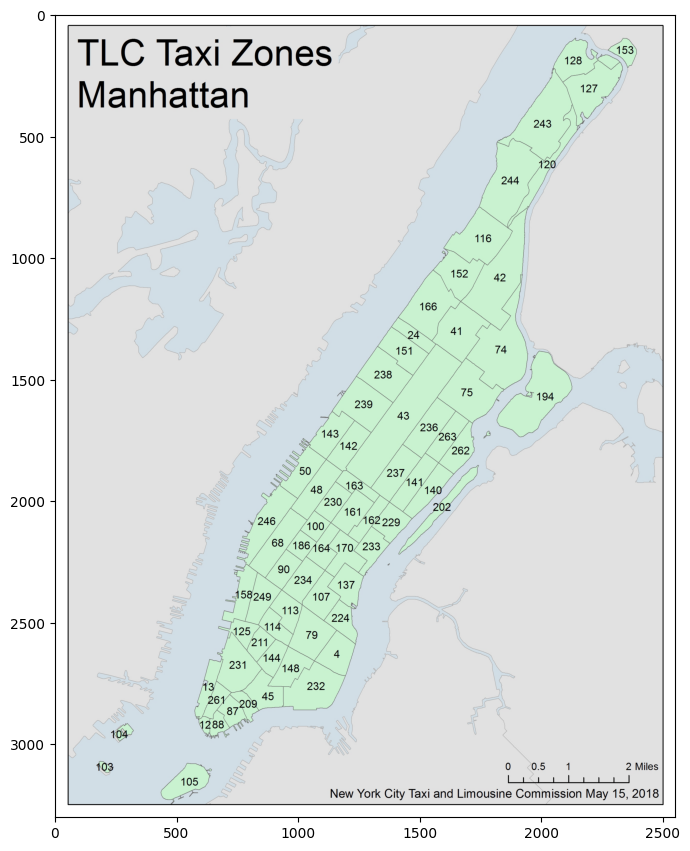

In [3]:
manhattan = plt.imread(path + "/taxi_zone_map_manhattan.jpg")
plt.figure(figsize=(8,14))
plt.imshow(manhattan) 
plt.show()

In [4]:
df = pd.read_parquet(path + "/yellow_tripdata_2022-01.parquet", engine= "auto")

In [5]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

## Utility Functions

In [6]:
df.shape

(2463931, 19)

In [7]:
def open_sample_from_file(path : str,column_to_search: str = None , search_value:str|float|int = None, show_columns = False) -> pd.DataFrame | pd.Series :
    """
    Helper function to read a file sample with optional search conditions
    """
    parquet = path.endswith('parquet')
    func = getattr(pd, f'read_csv')
    if parquet:
        engine = 'auto'
        func = getattr(pd, f'read_parquet')
        return func(path, engine)
    
    if column_to_search:
        if search_value != None:
            df = func(path)
            return df[df[column_to_search] == search_value]
        
        return func(path)[column_to_search] 

    if show_columns:
        return func(path).columns

    return func(path)


## Data Exploration

In [8]:
df2 = pd.read_csv(path + "/taxi+_zone_lookup.csv")
df2[['LocationID','Borough', 'Zone']].value_counts()

LocationID  Borough    Zone                     
1           EWR        Newark Airport               1
182         Bronx      Parkchester                  1
168         Bronx      Mott Haven/Port Morris       1
169         Bronx      Mount Hope                   1
170         Manhattan  Murray Hill                  1
                                                   ..
94          Bronx      Fordham South                1
95          Queens     Forest Hills                 1
96          Queens     Forest Park/Highland Park    1
97          Brooklyn   Fort Greene                  1
264         Unknown    NV                           1
Length: 264, dtype: int64

In [9]:
manhattan_df = open_sample_from_file(path + "/taxi+_zone_lookup.csv",column_to_search='Borough',search_value='Manhattan')

In [10]:
manhattan_df['Borough'].value_counts()

Manhattan    69
Name: Borough, dtype: int64

In [11]:
manhattan_df.head()

,LocationID,Borough,Zone,service_zone
3,4,Manhattan,Alphabet City,Yellow Zone
11,12,Manhattan,Battery Park,Yellow Zone
12,13,Manhattan,Battery Park City,Yellow Zone
23,24,Manhattan,Bloomingdale,Yellow Zone
40,41,Manhattan,Central Harlem,Boro Zone


In [12]:
manhattan_ids = manhattan_df[manhattan_df['service_zone']=='Yellow Zone'].LocationID.values

In [13]:
manhattan_ids

array([  4,  12,  13,  24,  43,  45,  48,  50,  68,  79,  87,  88,  90,
       100, 103, 104, 105, 107, 113, 114, 125, 137, 140, 141, 142, 143,
       144, 148, 151, 158, 161, 162, 163, 164, 170, 186, 194, 209, 211,
       224, 229, 230, 231, 232, 233, 234, 236, 237, 238, 239, 246, 249,
       261, 262, 263], dtype=int64)

In [14]:
filtered_df = df[df["PULocationID"].isin(manhattan_ids)]

In [15]:
geo_map = gpd.read_file(path + "/shapefiles/taxi_zones.shp")

In [16]:
geo_map.columns

Index(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough',
       'geometry'],
      dtype='object')

In [17]:
geo_map.total_bounds

array([ 913175.1090088 ,  120121.88125435, 1067382.50840516,
        272844.29400547])

In [18]:
selection = geo_map.borough.isin(["Manhattan"])

In [19]:
lonmin, latmin, lonmax, latmax = geo_map[selection].total_bounds

In [20]:
filtered_df = filtered_df[filtered_df['total_amount']<= 500]

In [21]:
filtered_df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.50,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.00,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.00,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.50,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0
6,2,2022-01-01 00:20:50,2022-01-01 00:34:58,1.0,5.07,1.0,N,233,87,1,17.00,0.5,0.5,5.20,0.0,0.3,26.00,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,None,90,170,0,8.00,0.0,0.5,2.39,0.0,0.3,13.69,NaN,NaN
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,None,107,75,0,16.80,0.0,0.5,4.35,0.0,0.3,24.45,NaN,NaN
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,None,113,246,0,11.22,0.0,0.5,2.00,0.0,0.3,16.52,NaN,NaN
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,None,148,164,0,12.40,0.0,0.5,0.00,0.0,0.3,15.70,NaN,NaN


In [22]:
total_min = filtered_df['total_amount'].min()
total_max = filtered_df['total_amount'].max()

In [23]:
total_min, total_max

(-253.3, 475.55)

In [24]:
filtered_df.sort_values(by='total_amount', ascending=False)[['PULocationID', 'DOLocationID', 'total_amount']]

,PULocationID,DOLocationID,total_amount
208370,68,265,475.55
779303,161,265,474.06
1080911,230,264,400.80
1416149,246,246,400.30
2024030,234,234,395.00
...,...,...,...
2309168,48,50,-202.24
1004571,186,265,-207.48
570338,263,263,-232.80
573593,162,233,-242.80


In [25]:
geo_map[selection]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
11,12,0.036661,0.000042,Battery Park,12,Manhattan,"POLYGON ((979908.772 196066.565, 979980.852 19..."
12,13,0.050281,0.000149,Battery Park City,13,Manhattan,"POLYGON ((980801.310 201248.869, 980697.386 20..."
23,24,0.047000,0.000061,Bloomingdale,24,Manhattan,"POLYGON ((995453.114 230274.267, 995312.583 23..."
40,41,0.052793,0.000143,Central Harlem,41,Manhattan,"POLYGON ((998716.913 234240.397, 999458.736 23..."
...,...,...,...,...,...,...,...
245,246,0.069467,0.000281,West Chelsea/Hudson Yards,246,Manhattan,"POLYGON ((983031.177 217138.506, 983640.320 21..."
248,249,0.036384,0.000072,West Village,249,Manhattan,"POLYGON ((983555.319 204876.901, 983469.158 20..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


In [26]:
geo_map[~selection]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."
5,6,0.150491,0.000606,Arrochar/Fort Wadsworth,6,Staten Island,"POLYGON ((966568.747 158679.855, 966615.256 15..."
...,...,...,...,...,...,...,...
255,256,0.067915,0.000169,Williamsburg (South Side),256,Brooklyn,"POLYGON ((995798.638 199155.970, 996223.601 19..."
256,257,0.058669,0.000139,Windsor Terrace,257,Brooklyn,"POLYGON ((989842.548 179997.856, 989842.643 17..."
257,258,0.089013,0.000366,Woodhaven,258,Queens,"POLYGON ((1027223.758 190451.926, 1027233.961 ..."
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."


## Heatmaps 

Heatmaps for data exploration, such as most visited areas, better payed areas, etc.

#### Comentario JP:
Me parece que el codigo de colores NO representa los pagos.
Creo que lo logré agregar

In [27]:
dfManhattan = df[df['PULocationID'].isin(df2.loc[df2['Borough']=='Manhattan', 'LocationID'])]
dfManhattan.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [28]:
# Total Ammount por PULocationID
dfPULocTA = dfManhattan[['PULocationID','total_amount']].groupby('PULocationID').mean(numeric_only=True)
dfPULocTA

,total_amount
PULocationID,
4,19.211511
12,22.535637
13,22.432118
24,16.243528
41,15.357543
...,...
246,16.853410
249,16.333510
261,22.095568


In [29]:
geo_map

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


#### El LocationID 105 no parece estar en el shapefile

In [40]:
df2[df2['LocationID'].isin([105,104,103])]

,LocationID,Borough,Zone,service_zone
102,103,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone
103,104,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone
104,105,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone


In [31]:
df2[(df2['Borough']=='Manhattan')]

,LocationID,Borough,Zone,service_zone
3,4,Manhattan,Alphabet City,Yellow Zone
11,12,Manhattan,Battery Park,Yellow Zone
12,13,Manhattan,Battery Park City,Yellow Zone
23,24,Manhattan,Bloomingdale,Yellow Zone
40,41,Manhattan,Central Harlem,Boro Zone
...,...,...,...,...
245,246,Manhattan,West Chelsea/Hudson Yards,Yellow Zone
248,249,Manhattan,West Village,Yellow Zone
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone


In [43]:
dfManhattan[dfManhattan['PULocationID'].isin([105,104,103])]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1725897,2,2022-01-23 13:03:48,2022-01-23 13:17:27,1.0,3.53,1.0,N,105,137,2,13.5,0.0,0.5,0.0,0.0,0.3,16.8,2.5,0.0


In [33]:
dfPULocTA[~dfPULocTA.index.isin(geo_map['LocationID'])]

,total_amount
PULocationID,
105,16.8


In [47]:
geo_map[geo_map['LocationID'].isin([105, 104, 103])]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
102,103,0.014306,0.000006,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,"POLYGON ((972079.575 190732.429, 972184.766 19..."
103,104,0.021221,0.000012,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,"POLYGON ((973172.666 194632.348, 973310.630 19..."
104,105,0.077425,0.000369,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,"POLYGON ((979605.759 191880.575, 979978.435 19..."


## Continua

In [48]:
# geo_map = dfPULocTA.join(other=geo_map.set_index('OBJECTID'))

## Hago la union del geo_map con la agrupacion por total_amount
## La hago con OBJECTID porque parece que el LocationID está algo mal
geo_map2 = geo_map.set_index('OBJECTID').join(other=dfPULocTA, how='inner')
#geo_map2['total_amount_scaled'] = (geo_map2['total_amount'] - geo_map2['total_amount'].min()) / (geo_map2['total_amount'].max() - geo_map2['total_amount'].min())
geo_map2['total_amount_scaled'] = (geo_map2['total_amount'] - geo_map2['total_amount'].mean()) / (geo_map2['total_amount'].std())


In [49]:
from matplotlib import colors
fracs = geo_map2['total_amount'] / geo_map2['total_amount_scaled'].max()
norm = colors.Normalize(fracs.min(), fracs.max())

<Axes: >

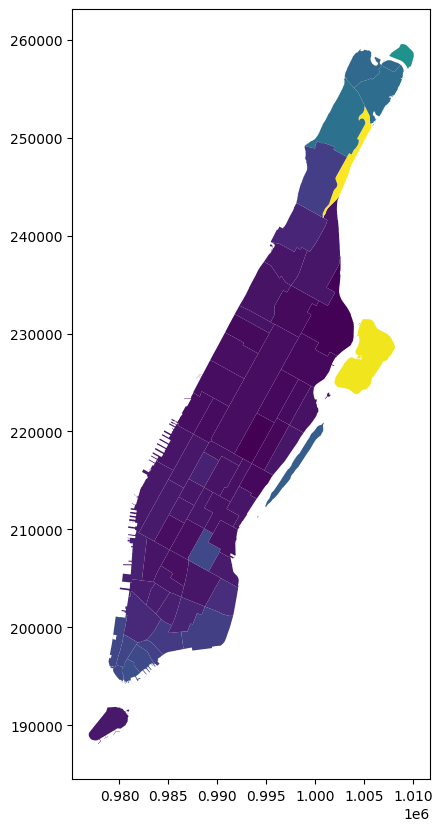

In [50]:
geo_map2.plot(column='total_amount', cmap = 'viridis', figsize=(15,10))

Text(0.5, 1.0, 'Heatmap of payments')

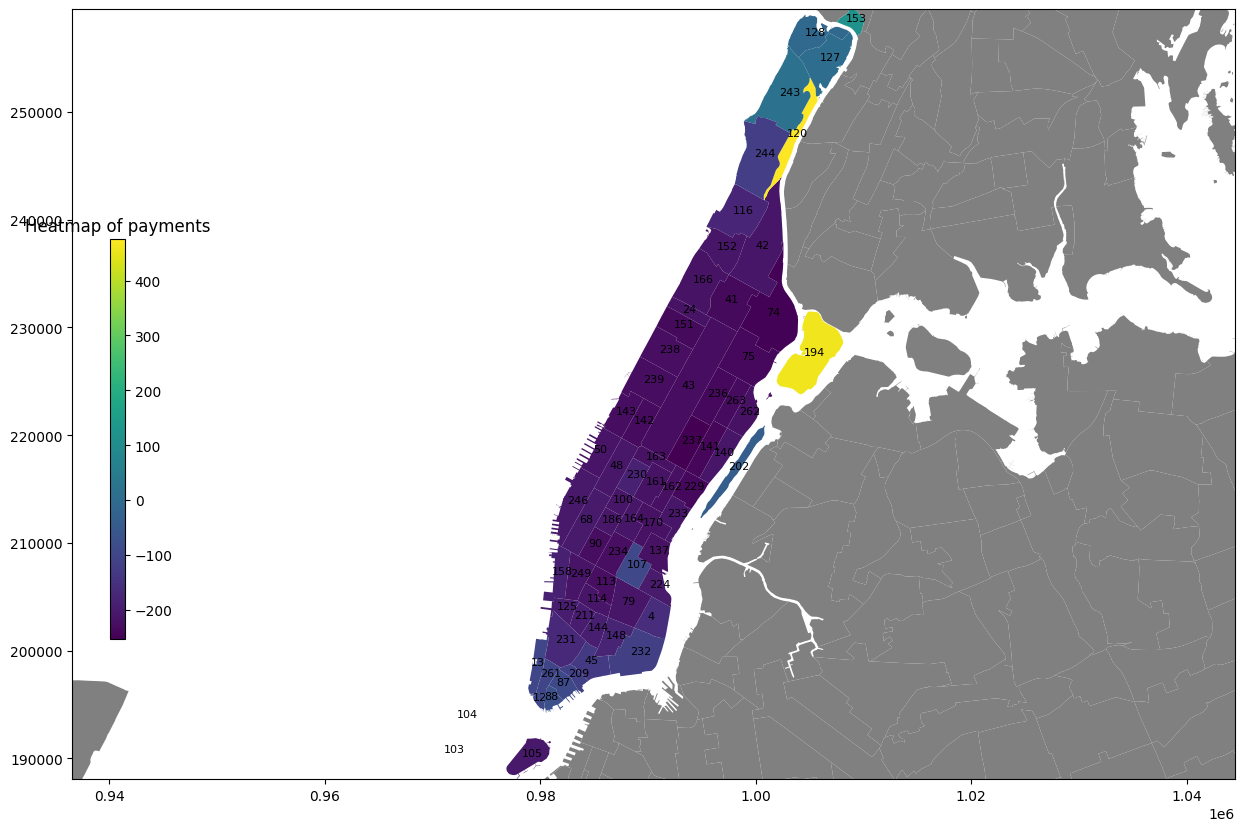

In [52]:
cmap = 'viridis'
fig, ax = plt.subplots(1, figsize=(15, 10))
ax = geo_map2.plot(ax=ax,column='total_amount', cmap = cmap, figsize=(15,10))
ax = geo_map[~selection].plot(ax=ax,color = 'gray', figsize=(15,10))
ax.axis("equal")
ax.axis([lonmin, lonmax, latmin, latmax])

for x, y, label in zip(geo_map[selection].centroid.x, geo_map[selection].centroid.y, geo_map[selection].OBJECTID):
    ax.annotate(label, xy=(x, y), xytext=(-5, 0), textcoords="offset points", color = 'black', fontsize = 8)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=total_min, vmax=total_max), cmap = cmap)
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)
plt.title('Heatmap of payments') 

In [39]:
dfPULocTA.sort_values(by=['total_amount'], ascending=False)

,total_amount
PULocationID,
120,52.081667
194,51.213662
153,33.621000
243,28.484511
127,27.765506
...,...
236,15.172972
229,15.159916
141,15.013178
